## About the Problem:
Using the machine learning tools, we need to analyze the information about the passensgers of Titanic and predict which passenger has survived. This problem has been published by Kaggle and is widely used for learning basic concepts of Machine Learning

## Exploring The Data:

### Data Dictionary
![Imgur](https://i.imgur.com/bkNeXxE.png)

## Variable Notes
**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

**Sibling** = brother, sister, stepbrother, stepsister

**Spouse** = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

**Parent** = mother, father

**Child** = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

## Load Libraries

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pandas.plotting import scatter_matrix
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np

## Load Data

In [5]:
spark = SparkSession.builder.appName('tps-2021-ml-with-pyspark').getOrCreate()
df = spark.read.csv(r'Y:\ML - DL - NLP - CV\Work Space_coding\Big Data Project\tabular-playground-series-apr-2021\train.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



## Show Dataset


In [6]:
df.show(5)

+-----------+--------+------+----------------+----+----+-----+-----+---------+-----+------+--------+
|PassengerId|Survived|Pclass|            Name| Sex| Age|SibSp|Parch|   Ticket| Fare| Cabin|Embarked|
+-----------+--------+------+----------------+----+----+-----+-----+---------+-----+------+--------+
|          0|       1|     1|Oconnor, Frankie|male|NULL|    2|    0|   209245|27.14|C12239|       S|
|          1|       0|     3|     Bryan, Drew|male|NULL|    0|    0|    27323|13.35|  NULL|       S|
|          2|       0|     3|  Owens, Kenneth|male|0.33|    1|    2|CA 457703|71.29|  NULL|       S|
|          3|       0|     3|   Kramer, James|male|19.0|    0|    0| A. 10866|13.04|  NULL|       S|
|          4|       1|     3|   Bond, Michael|male|25.0|    0|    0|   427635| 7.76|  NULL|       S|
+-----------+--------+------+----------------+----+----+-----+-----+---------+-----+------+--------+
only showing top 5 rows



Now, Data grouping by Survived for checking the classes are perfectly balanced!!

In [7]:
df.groupby('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|42774|
|       0|57226|
+--------+-----+



**Survived class not balanced!!**

## Summary statistics for numeric variables

In [8]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().show()

+-------+-----------------+-------------------+------------------+------------------+------------------+
|summary|      PassengerId|           Survived|            Pclass|             SibSp|             Parch|
+-------+-----------------+-------------------+------------------+------------------+------------------+
|  count|           100000|             100000|            100000|            100000|            100000|
|   mean|          49999.5|            0.42774|           2.10691|           0.39769|           0.45456|
| stddev|28867.65779668774|0.49475341353991886|0.8377274436072256|0.8625659998522097|0.9500759089895537|
|    min|                0|                  0|                 1|                 0|                 0|
|    max|            99999|                  1|                 3|                 8|                 9|
+-------+-----------------+-------------------+------------------+------------------+------------------+



## Correlations

Checking Correlations between independent variables


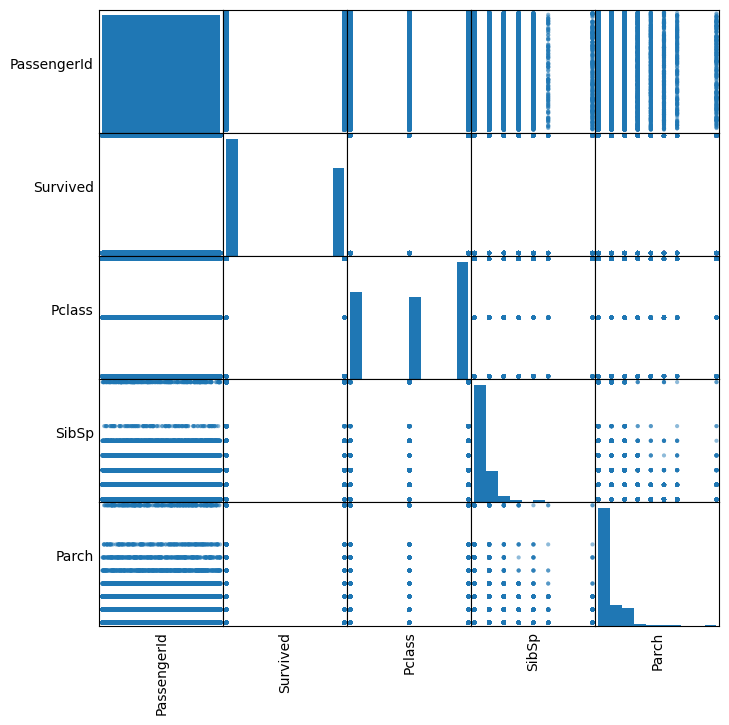

In [9]:
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Data preparation and feature engineering

### 1. Missing Data Handling:


In [10]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+----+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex| Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+----+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|3292|    0|    0|  4623| 134|67866|     250|
+-----------+--------+------+----+---+----+-----+-----+------+----+-----+--------+



In [11]:
dataset = df.replace('null', None)\
        .dropna(how='any')

**Again check missing data**

In [12]:
dataset.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



## 2. Unnecessary columns dropping


In [13]:
dataset = dataset.drop('PassengerId')
dataset = dataset.drop('Ticket')
dataset = dataset.drop('Fare')
dataset = dataset.drop('Cabin')
dataset = dataset.drop('Embarked')
dataset = dataset.drop('Name')
dataset.show()

+--------+------+------+----+-----+-----+
|Survived|Pclass|   Sex| Age|SibSp|Parch|
+--------+------+------+----+-----+-----+
|       0|     1|  male|27.0|    2|    1|
|       0|     2|  male|66.0|    0|    0|
|       0|     1|  male|60.0|    0|    0|
|       0|     3|  male|36.0|    0|    0|
|       1|     1|female|44.0|    0|    1|
|       1|     1|female|61.0|    0|    4|
|       0|     1|female|53.0|    1|    1|
|       1|     1|female|35.0|    0|    2|
|       1|     1|female|67.0|    1|    0|
|       1|     1|  male|54.0|    0|    0|
|       1|     1|female|69.0|    1|    0|
|       1|     2|female| 7.0|    0|    1|
|       0|     1|  male|43.0|    0|    0|
|       1|     1|  male|63.0|    0|    0|
|       0|     1|  male|45.0|    1|    0|
|       1|     1|female|34.0|    1|    0|
|       1|     1|  male|27.0|    0|    0|
|       1|     1|female|28.0|    0|    1|
|       0|     1|female|36.0|    0|    2|
|       1|     1|female| 5.0|    1|    0|
+--------+------+------+----+-----

## 3. Features Convert into Vector

In [14]:
sex_in = StringIndexer(inputCol="Sex", outputCol="Sex_encoding")
df1 = sex_in.fit(dataset).transform(dataset)
df1.show() 

+--------+------+------+----+-----+-----+------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|Sex_encoding|
+--------+------+------+----+-----+-----+------------+
|       0|     1|  male|27.0|    2|    1|         1.0|
|       0|     2|  male|66.0|    0|    0|         1.0|
|       0|     1|  male|60.0|    0|    0|         1.0|
|       0|     3|  male|36.0|    0|    0|         1.0|
|       1|     1|female|44.0|    0|    1|         0.0|
|       1|     1|female|61.0|    0|    4|         0.0|
|       0|     1|female|53.0|    1|    1|         0.0|
|       1|     1|female|35.0|    0|    2|         0.0|
|       1|     1|female|67.0|    1|    0|         0.0|
|       1|     1|  male|54.0|    0|    0|         1.0|
|       1|     1|female|69.0|    1|    0|         0.0|
|       1|     2|female| 7.0|    0|    1|         0.0|
|       0|     1|  male|43.0|    0|    0|         1.0|
|       1|     1|  male|63.0|    0|    0|         1.0|
|       0|     1|  male|45.0|    1|    0|         1.0|
|       1|

In [15]:
required_features = ['Survived',
                    'Pclass',
                    'SibSp',
                    'Parch',
                     'Age',
                     'Sex_encoding'
                   ]

assembler = VectorAssembler(inputCols=required_features, outputCol='features')

transformed_data = assembler.transform(df1)

In [16]:
transformed_data.show()

+--------+------+------+----+-----+-----+------------+--------------------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|Sex_encoding|            features|
+--------+------+------+----+-----+-----+------------+--------------------+
|       0|     1|  male|27.0|    2|    1|         1.0|[0.0,1.0,2.0,1.0,...|
|       0|     2|  male|66.0|    0|    0|         1.0|[0.0,2.0,0.0,0.0,...|
|       0|     1|  male|60.0|    0|    0|         1.0|[0.0,1.0,0.0,0.0,...|
|       0|     3|  male|36.0|    0|    0|         1.0|[0.0,3.0,0.0,0.0,...|
|       1|     1|female|44.0|    0|    1|         0.0|[1.0,1.0,0.0,1.0,...|
|       1|     1|female|61.0|    0|    4|         0.0|[1.0,1.0,0.0,4.0,...|
|       0|     1|female|53.0|    1|    1|         0.0|[0.0,1.0,1.0,1.0,...|
|       1|     1|female|35.0|    0|    2|         0.0|[1.0,1.0,0.0,2.0,...|
|       1|     1|female|67.0|    1|    0|         0.0|[1.0,1.0,1.0,0.0,...|
|       1|     1|  male|54.0|    0|    0|         1.0|[1.0,1.0,0.0,0.0,...|
|       1|  

## 4. Train and Test Split
Randomly split data into train and test sets, and set seed for reproducibility.

In [17]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

In [18]:
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 24692
Test Dataset Count: 6189


# Machine learning Model Building


## 1. Random Forest Classifier

Random forest is a supervised learning algorithm which is used for both classification and regression cases, as well. But however, it is mainly used for classification problems. As we know that a forest is made up of trees and more trees mean more robust forests, in a similar way, random forest algorithm creates decision trees on data samples and then gets the prediction from each of them and finally selects the best solution by means of voting. It is an ensemble method which is better than a single decision tree because it reduces the over-fitting by averaging the result.

In [19]:
rf = RandomForestClassifier(labelCol='Survived', 
                            featuresCol='features',
                            maxDepth=5)
model = rf.fit(training_data)
rf_predictions = model.transform(test_data)

**Evaluate our Random Forest Classifier model.**

In [20]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Survived', metricName = 'accuracy')
print('Random Forest classifier Accuracy:', multi_evaluator.evaluate(rf_predictions))

Random Forest classifier Accuracy: 1.0


## 2. Decision Tree Classifier

Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, while not requiring feature scaling and are able to capture non-linearities and feature interactions.

In [21]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Survived', maxDepth = 3)
dtModel = dt.fit(training_data)
dt_predictions = dtModel.transform(test_data)
dt_predictions.select('Sex_encoding', 'Pclass','SibSp', 'Parch', 'Age', 'Survived').show(10)

+------------+------+-----+-----+----+--------+
|Sex_encoding|Pclass|SibSp|Parch| Age|Survived|
+------------+------+-----+-----+----+--------+
|         0.0|     1|    1|    0|0.67|       0|
|         0.0|     1|    1|    1| 1.0|       0|
|         0.0|     1|    1|    0| 2.0|       0|
|         0.0|     1|    1|    2| 2.0|       0|
|         0.0|     1|    1|    2| 2.0|       0|
|         0.0|     1|    1|    2| 3.0|       0|
|         0.0|     1|    0|    0| 4.0|       0|
|         0.0|     1|    0|    0| 5.0|       0|
|         0.0|     1|    0|    0| 5.0|       0|
|         0.0|     1|    0|    2| 5.0|       0|
+------------+------+-----+-----+----+--------+
only showing top 10 rows



**Evaluate our Decision Tree model.**

In [22]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Survived', metricName = 'accuracy')
print('Decision Tree Accuracy:', multi_evaluator.evaluate(dt_predictions))

Decision Tree Accuracy: 1.0


## 3. Gradient-boosted Tree classifier Model

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

In [23]:
gb = GBTClassifier(labelCol = 'Survived', featuresCol = 'features')
gbModel = gb.fit(training_data)
gb_predictions = gbModel.transform(test_data)

**Evaluate our Gradient-Boosted Tree Classifier.**

In [24]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Survived', metricName = 'accuracy')
print('Gradient-boosted Trees Accuracy:', multi_evaluator.evaluate(gb_predictions))

Gradient-boosted Trees Accuracy: 1.0


# Make Sumbission file

In [25]:
df_pd = gb_predictions.toPandas()

In [26]:
df_pd.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Sex_encoding,features,rawPrediction,probability,prediction
0,0,1,female,0.67,1,0,0.0,"[0.0, 1.0, 1.0, 0.0, 0.67, 0.0]","[1.5435020027249977, -1.5435020027249977]","[0.9563534785727079, 0.043646521427292084]",0.0
1,0,1,female,1.00,1,1,0.0,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0]","[1.5435020027249973, -1.5435020027249973]","[0.9563534785727079, 0.043646521427292084]",0.0
2,0,1,female,2.00,1,0,0.0,"[0.0, 1.0, 1.0, 0.0, 2.0, 0.0]","[1.5435020027249977, -1.5435020027249977]","[0.9563534785727079, 0.043646521427292084]",0.0
3,0,1,female,2.00,1,2,0.0,"[0.0, 1.0, 1.0, 2.0, 2.0, 0.0]","[1.5435020027249973, -1.5435020027249973]","[0.9563534785727079, 0.043646521427292084]",0.0
4,0,1,female,2.00,1,2,0.0,"[0.0, 1.0, 1.0, 2.0, 2.0, 0.0]","[1.5435020027249973, -1.5435020027249973]","[0.9563534785727079, 0.043646521427292084]",0.0


In [27]:
df_pd.to_csv("gbModel.csv",index = False)

In [28]:
gb_df = pd.read_csv("./gbModel.csv")

In [29]:
gb_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Sex_encoding,features,rawPrediction,probability,prediction
0,0,1,female,0.67,1,0,0.0,"[0.0,1.0,1.0,0.0,0.67,0.0]","[1.5435020027249977,-1.5435020027249977]","[0.9563534785727079,0.043646521427292084]",0.0
1,0,1,female,1.00,1,1,0.0,"[0.0,1.0,1.0,1.0,1.0,0.0]","[1.5435020027249973,-1.5435020027249973]","[0.9563534785727079,0.043646521427292084]",0.0
2,0,1,female,2.00,1,0,0.0,"[0.0,1.0,1.0,0.0,2.0,0.0]","[1.5435020027249977,-1.5435020027249977]","[0.9563534785727079,0.043646521427292084]",0.0
3,0,1,female,2.00,1,2,0.0,"[0.0,1.0,1.0,2.0,2.0,0.0]","[1.5435020027249973,-1.5435020027249973]","[0.9563534785727079,0.043646521427292084]",0.0
4,0,1,female,2.00,1,2,0.0,"[0.0,1.0,1.0,2.0,2.0,0.0]","[1.5435020027249973,-1.5435020027249973]","[0.9563534785727079,0.043646521427292084]",0.0


In [31]:
submission  = pd.read_csv(r"Y:\ML - DL - NLP - CV\Work Space_coding\Big Data Project\tabular-playground-series-apr-2021\sample_submission.csv")
submission = submission.drop("Survived",axis=1)
submission.head()

,PassengerId
0,100000
1,100001
2,100002
3,100003
4,100004


In [32]:
results = pd.concat([submission,gb_df.Survived],axis = 1)

In [33]:
results.to_csv("submission.csv", index = False)